<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Convolutions/Architecture_styles_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Architecture styles

We're going to use kaggle dataset for architecture styles

## Imports and installations

In [ ]:
%%capture
!pip install kaggle

In [4]:
%%capture
!pip install rich

In [5]:
%%capture
!pip install wandb

In [ ]:
%%capture
!pip install lightning

In [8]:
import albumentations as A
import glob
import lightning as L
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torchvision.models as models
import wandb

from albumentations.pytorch import ToTensorV2
from google.colab import userdata
from IPython.display import clear_output
import matplotlib.pyplot as plt
from PIL import Image
from torch.optim.lr_scheduler import LambdaLR
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset, random_split
from torchmetrics import Accuracy
from torchvision import transforms

from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, RichProgressBar
from lightning.pytorch.loggers import WandbLogger

In [9]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'
os.environ["WANDB_API_KEY"] = userdata.get('wandb')

In [ ]:
%%capture
!kaggle datasets download -d dumitrux/architectural-styles-dataset

In [ ]:
!unzip architectural-styles-dataset.zip
clear_output(wait=True)

### Set seeds

In [14]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [15]:
seed_everything()

### Set logger

In [98]:
wandb_logger = WandbLogger(project="ArchStyles", log_model='all')

In [17]:
!mkdir -p /content/lightning_logs

### Set scheduler func to overclock Adam

In [18]:
def lr_lambda(epoch: int) -> float:
  """
  Overclocking Adam

  :param epoch: int epoch
  return learning rate
  """
  return 1e-6 if epoch == 0 else 3e-4

## Dataset preparation

Create config

In [19]:
class CFG:
  train_perc = 0.8
  test_val_perc = 0.5
  batch_size = 32
  epochs = 10

In [20]:
basic_augs = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()])

In [21]:
class ArchitecturalStylesDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = sorted(os.listdir(data_dir))
        self.label2name = {label: class_name for label, class_name in enumerate(self.classes)}

        self.files = []
        for class_name in self.classes:
            class_dir = os.path.join(data_dir, class_name)
            extended_list = [(os.path.join(class_dir, fname), class_name) for fname in os.listdir(class_dir)]
            self.files.extend(extended_list)
            print(class_name, self.files)


    def __len__(self):
        return len(self.files)


    def __getitem__(self, idx):
        img_path, class_name = self.files[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.classes.index(class_name)
        if self.transform:
            augmented = self.transform(image=np.array(image))
            image = augmented['image']
        return image, label

In [22]:
%%capture
dataset = ArchitecturalStylesDataset(data_dir='architectural-styles-dataset', transform=basic_augs)

In [23]:
print("Class Name to Integer Label Mapping:")
for key, value in dataset.label2name.items():
    print(f"{key}: {value}")

Class Name to Integer Label Mapping:
0: Achaemenid architecture
1: American Foursquare architecture
2: American craftsman style
3: Ancient Egyptian architecture
4: Art Deco architecture
5: Art Nouveau architecture
6: Baroque architecture
7: Bauhaus architecture
8: Beaux-Arts architecture
9: Byzantine architecture
10: Chicago school architecture
11: Colonial architecture
12: Deconstructivism
13: Edwardian architecture
14: Georgian architecture
15: Gothic architecture
16: Greek Revival architecture
17: International style
18: Novelty architecture
19: Palladian architecture
20: Postmodern architecture
21: Queen Anne architecture
22: Romanesque architecture
23: Russian Revival architecture
24: Tudor Revival architecture


#### Split into train and val datasets

In [24]:
train_size = int(CFG.train_perc * len(dataset))
test_val_size = len(dataset) - train_size
train_data, test_val_data = random_split(dataset, [train_size, test_val_size])

#### Add more augs to train dataset

In [63]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.RandomCrop(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=30, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()])


In [64]:
train_data.dataset.transform = train_transform

#### Split val into val and test

In [65]:
val_size = int(CFG.test_val_perc * len(test_val_data))
test_size = len(test_val_data) - val_size
val_data, test_data = random_split(test_val_data, [val_size, test_size])

#### Create dataloaders

In [66]:
train_loader = DataLoader(train_data, batch_size=CFG.batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=CFG.batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=CFG.batch_size, shuffle=False)

In [61]:
def visualize(loader, model=False):
    half_batch = 16
    img_batch, label_batch = next(iter(loader))

    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    for i, (img, label) in enumerate(zip(img_batch, label_batch)):
        if i >= half_batch:
            break
        row = i // 4
        col = i % 4
        img = img.unsqueeze(0)  # Add batch dimension

        text = f'{int(label)}:{dataset.label2name[int(label)]}'
        if model:
            model.to('cpu')
            model.eval()
            logits = model(img)
            predicted_label = torch.argmax(logits, dim=1)
            text = f"Pred {int(predicted_label.item())}:{dataset.label2name[int(predicted_label.item())]}\nTrue {text}"

        img = img.squeeze(0).permute(1, 2, 0)

        img = (img - img.min()) / (img.max() - img.min())
        axes[row, col].imshow(img)
        axes[row, col].set_title(text)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

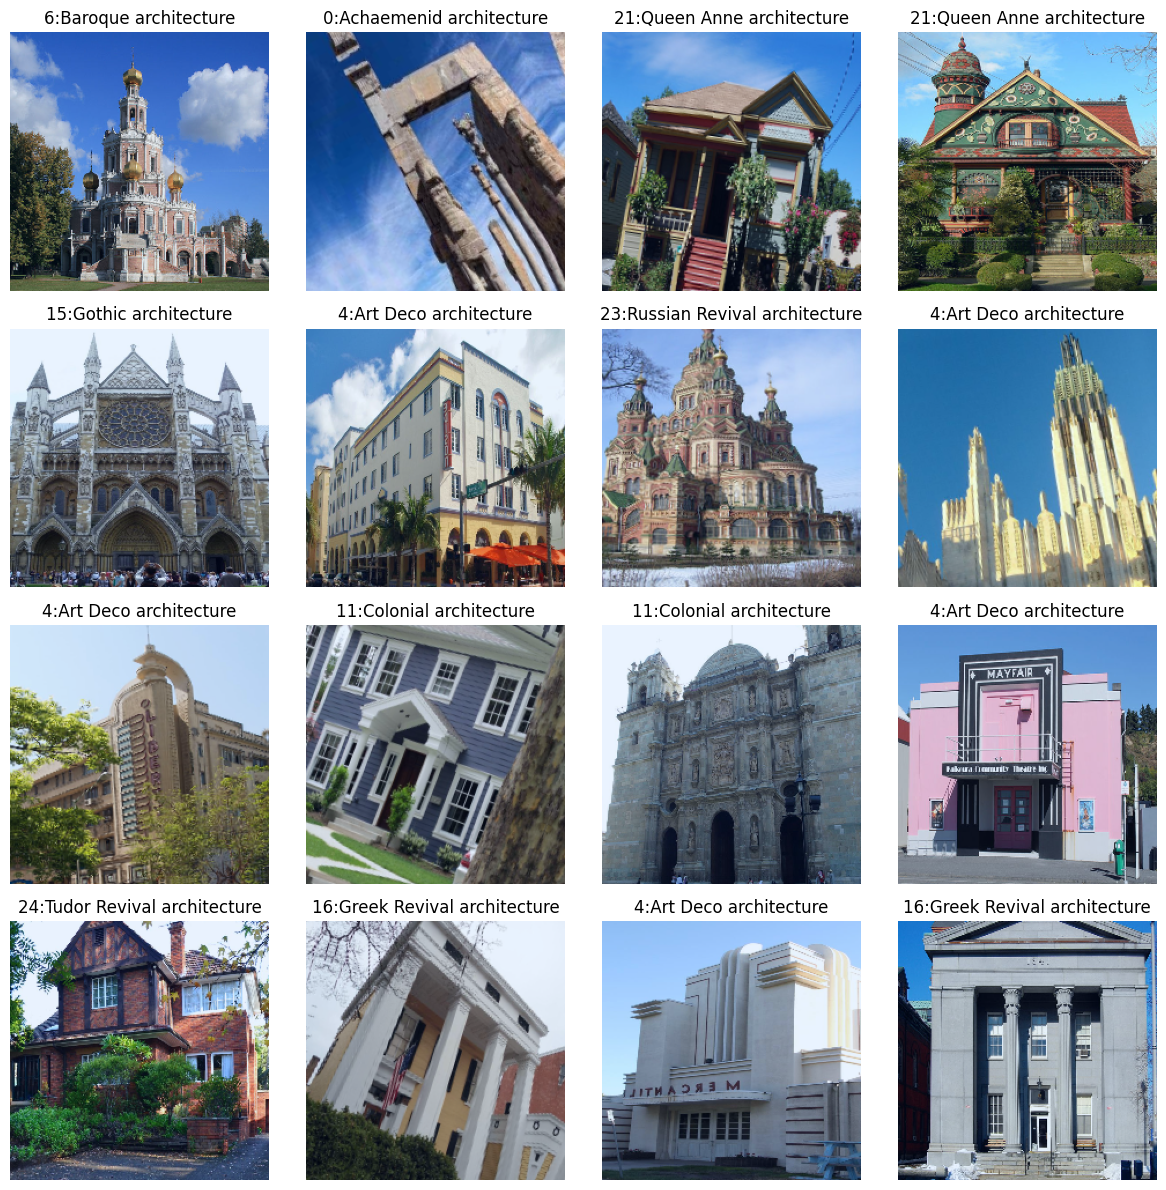

In [62]:
visualize(train_loader)

## Model architecture

Define mobilenet v2 model
(yeah, inverted residuals, bottleneck, 1x1 kernels, depthwise split)

In [67]:
class CustomModel(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.mobilenet = models.mobilenet_v2(weights=models.mobilenetv2.MobileNet_V2_Weights.DEFAULT)
    self.mobilenet.classifier[1] = nn.Linear(self.mobilenet.last_channel, num_classes)

  def forward(self, x):
    return self.mobilenet(x)

Define lightning code

In [103]:
class CustomLightning(L.LightningModule):
  def __init__(self, num_classes, learning_rate=3e-4):
    super().__init__()
    self.save_hyperparameters()
    self.model = CustomModel(num_classes)
    self.criterion = nn.CrossEntropyLoss()

    self.train_acc = Accuracy(num_classes=num_classes, average='weighted', task='multiclass')
    self.valid_acc = Accuracy(num_classes=num_classes, average='weighted', task='multiclass')
    self.test_acc = Accuracy(num_classes=num_classes, average='weighted', task='multiclass')


  def forward(self, x):
    return self.model(x)


  def test_step(self, batch, batch_idx):

      X, y = batch
      logits = self(X)
      loss = self.criterion(logits, y)
      preds = torch.argmax(logits, dim=1)
      self.test_acc(preds, y)
      self.log('test_loss', loss, prog_bar=True)
      self.log('test_acc', self.test_acc.compute(), prog_bar=True)


  def training_step(self, batch, batch_idx):
    X, y = batch
    logits = self(X)
    loss = self.criterion(logits, y)
    preds = torch.argmax(logits, dim=1)
    self.train_acc(preds, y)
    self.log('train_loss', loss, on_step=True, prog_bar=True)
    self.log('train_acc', self.train_acc.compute(), on_step=True, prog_bar=True)
    return loss


  def validation_step(self, batch, batch_idx):
    X, y = batch
    logits = self(X)
    loss = self.criterion(logits, y)
    preds = torch.argmax(logits, dim=1)
    self.valid_acc(preds, y)
    self.log('val_loss', loss, on_step=True, prog_bar=True)
    self.log('val_acc', self.valid_acc.compute(), on_step=True, prog_bar=True)
    return loss


  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hparams.learning_rate)
    return optimizer

  def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hparams.learning_rate)
      scheduler = StepLR(optimizer, step_size=1, gamma=0.9)
      return [optimizer], [scheduler]

#### Set basic learning

In [95]:
lightning_model = CustomLightning(len(dataset.classes))

In [96]:
model_checkpoint = ModelCheckpoint(
    monitor='val_loss',    # Metric
    save_top_k=5,          # Number of best models to save
    mode='min')            # Save models which minimize the metric

early_stopping = EarlyStopping(
    monitor='val_loss',    # Metric
    patience=3,            # Number of epochs to wait after improvement before stopping
    mode='min')            # Stop when the monitored metric stops decreasing

progress_bar = RichProgressBar(refresh_rate=1)

In [102]:
wandb_logger = WandbLogger(project="ArchStyles", log_model='all')
trainer = Trainer(logger=wandb_logger,
                  callbacks=[progress_bar, model_checkpoint, early_stopping],
                  max_epochs=CFG.epochs)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [104]:
trainer.fit(lightning_model, train_loader, val_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model     │ CustomModel        │  2.3 M │
│ 1 │ criterion │ CrossEntropyLoss   │      0 │
│ 2 │ train_acc │ MulticlassAccuracy │      0 │
│ 3 │ valid_acc │ MulticlassAccuracy │      0 │
│ 4 │ test_acc  │ MulticlassAccuracy │      0 │
└───┴───────────┴────────────────────┴────────┘

Trainable params: 2.3 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.3 M                                                                                                
Total estimated model params size (MB): 9

Output()

In [105]:
wandb.finish()

### Continue learning

In [106]:
more_trainer = Trainer(callbacks=[progress_bar, model_checkpoint, early_stopping], max_epochs=2)
more_trainer.fit(lightning_model, train_loader, val_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory ./ArchStyles/dnmuwfd7/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model     │ CustomModel        │  2.3 M │
│ 1 │ criterion │ CrossEntropyLoss   │      0 │
│ 2 │ train_acc │ MulticlassAccuracy │      0 │
│ 3 │ valid_acc │ MulticlassAccuracy │      0 │
│ 4 │ test_acc  │ MulticlassAccuracy │      0 │
└───┴───────────┴────────────────────┴────────┘

Trainable params: 2.3 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.3 M                                                                                                
Total estimated model params size (MB): 9

Output()

In [107]:
lightning_model.eval()
more_trainer.validate(lightning_model, val_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_acc_epoch       │    0.6721036434173584     │
│      val_loss_epoch       │    1.1169841289520264     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss_epoch': 1.1169841289520264, 'val_acc_epoch': 0.6721036434173584}]

#### Lightning Test

In [108]:
best_model_path = more_trainer.checkpoint_callback.best_model_path
test_model = CustomLightning.load_from_checkpoint(best_model_path)
test_model.eval()
test_trainer = Trainer()
test_trainer.test(test_model, dataloaders=test_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6994213461875916     │
│         test_loss         │    0.9997447729110718     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.9997447729110718, 'test_acc': 0.6994213461875916}]

#### Show results

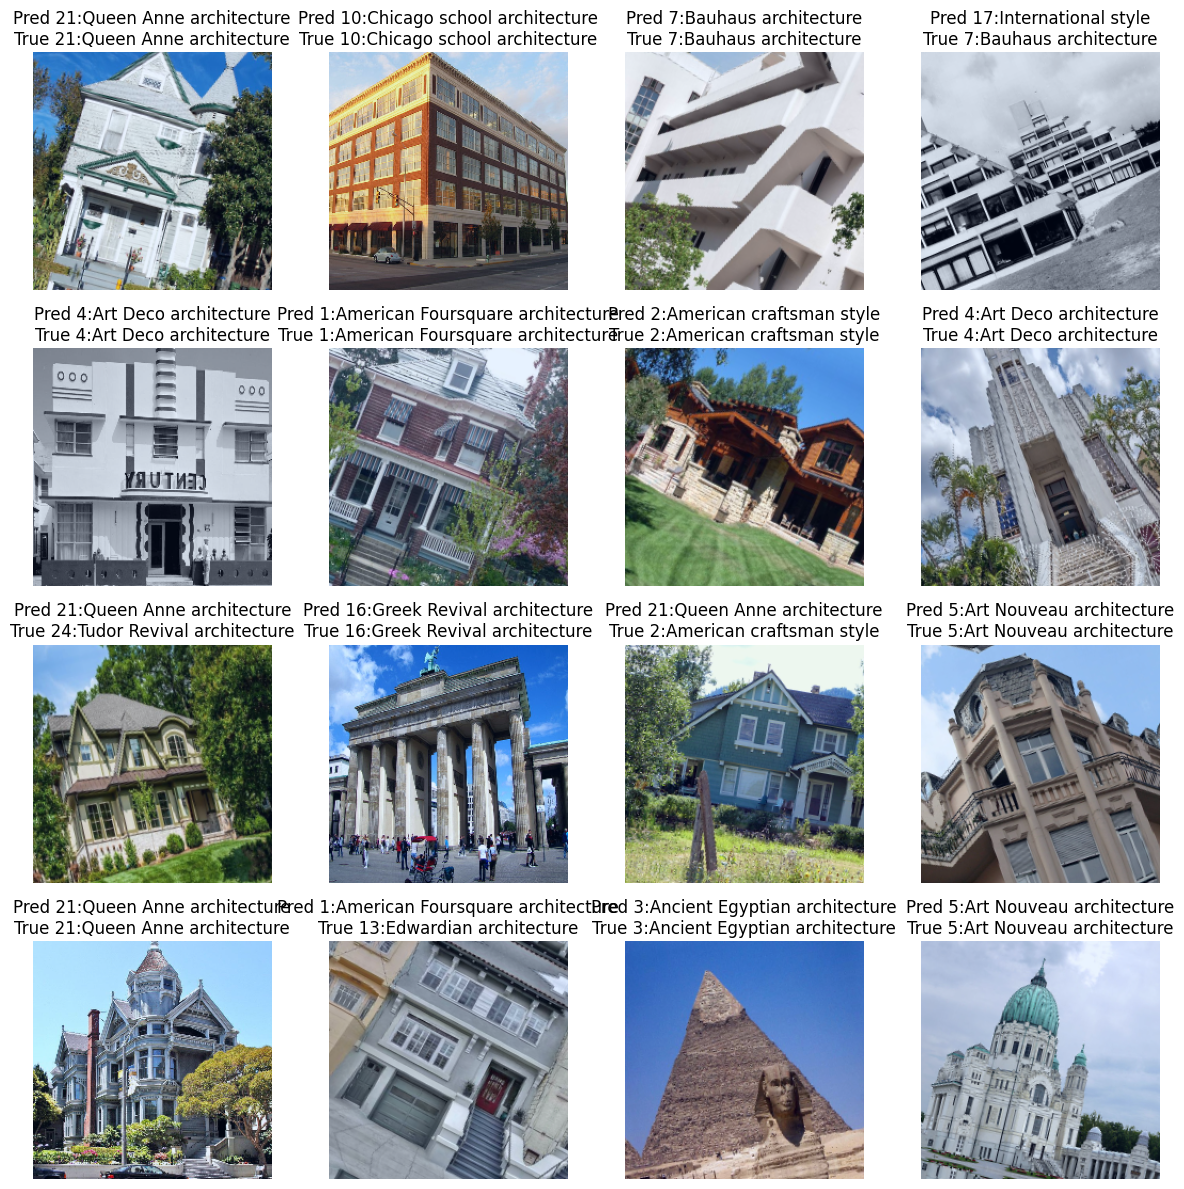

In [109]:
visualize(test_loader, test_model)

## Average checkpoints

Average checkpoints - combining multiple saved models trained at different stages during the training process to create a single model with improved performance. This is typically achieved by averaging the weights of corresponding parameters across multiple checkpoints. Averaging checkpoints can help mitigate overfitting and improve the generalization ability of the model by capturing different snapshots of the training process. It can also provide smoother convergence and robustness to hyperparameters, leading to better overall performance on unseen data.

So we sort checkpoints (best to worst) and iterate through them on eval\test dataset to find the best one.

#### Load all best model states

In [110]:
import glob
checkpoint_paths = glob.glob('/content/lightning_logs/version_*/checkpoints/*.ckpt')

#### Compare their performance on test dataloader

In [111]:
test_results = {}
for checkpoint_path in checkpoint_paths + [trainer.checkpoint_callback.best_model_path, more_trainer.checkpoint_callback.best_model_path]:
    model = CustomLightning.load_from_checkpoint(checkpoint_path)
    model.eval()
    result = test_trainer.test(model, dataloaders=test_loader)
    test_results[checkpoint_path] = result

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6908653378486633     │
│         test_loss         │     1.034117579460144     │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6827865242958069     │
│         test_loss         │    1.0079797506332397     │
└───────────────────────────┴───────────────────────────┘

#### Average them

In [112]:
seed_everything()

In [ ]:
avg_state_dict = None
for checkpoint_path in checkpoint_paths:
    model = CustomLightning.load_from_checkpoint(checkpoint_path)
    model.eval()
    model_state_dict = model.state_dict()
    if avg_state_dict is None:
        avg_state_dict = model_state_dict
    else:
        for key in avg_state_dict:
            avg_state_dict[key] = avg_state_dict[key] + model_state_dict[key]

for key in avg_state_dict:
    avg_state_dict[key] = avg_state_dict[key] / len(checkpoint_paths)


#### Load average model to a new instance

In [ ]:
averaged_model = CustomLightning(len(dataset.classes))
averaged_model.load_state_dict(avg_state_dict)
averaged_model.eval()

In [148]:
result = test_trainer.test(averaged_model, dataloaders=test_loader)
print(result)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6657551527023315     │
│         test_loss         │    1.0647298097610474     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.0647298097610474, 'test_acc': 0.6657551527023315}]


Well, in the end can't say it works properly. Even though the seeds are frozen, average still provides slightly different results each time.

Also judging by initial best rates before averaging - the results were higher (depends on run each time)